#  Data Processing

In this notebook, we perform preprocessing on our reddit data. The original file, `May2015_subset.fthr`, contains the original features listed below.

Some rows were removed from this data. These include comments that were deleted before the data was acquired and comments that did not belong to one of the five popular subreddits we chose: **worldnews, movies, gaming, science, food**.

Another file, `df_final.pkl` was obtained using `PRAW`, the python reddit api wrapper. This file contains information about the threads that each comment is on, and was merged with our original data. The features in this dataset are listed as PRAW features.

Finally, some featues were engineered from the combined data. These are listed as engineered features.

**Missing Values**: About 31.339% of the comments were parent comments. As a result, they do not have a `parent_score`, `parent_cos_angle`, etc.

### Original Feaures
- `created_utc`: the time in seconds from an origin when the comment was posted 
- `ups`: number of upvotes on the comment
- `subreddit_id`: id of the specific subreddit
- `link_id`: id of the particular comment thread
- `name`: name of the comment
- `score_hidden`: 1 if the score of the comment was hidden; 0 else
- `author_flair_css_class`: CSS class for the comment flair
- `author_flair_text`: flair text for the comment
- `id`: id of the comment (basically the same as comment name)
- `removal_reason`: reason a comment was removed (either `legal` or `None`)
- `gilded`: the number of gilded tags (~ premium likes) on the comment 
- `downs`: number of downvotes on the comment
- `archived`: if the thread was archived (no new comments, no new likes) 
- `author`: author's reddit username
- `score`: number of upvotes
- `retrieved_on`: The time (in seconds) when the comment was pulled to create the dataset. 
- `body`: the comment itself
- `distinguished`: the type of user on the page. Either `moderator`, `admin`, or `None`. 
- `edited`: whether (1) or not (0) the comment has been edited
- `controversiality`: a Boolean indicating whether (1) or not (0) a comment is controversial -- i.e., popular comments that are getting closely the same amount of upvotes as downvotes. 
- `parent_id`: the id of the comment that this comment was replying to. `None` if the comment is not a reply

### PRAW Features
- `url`: url of thread comment is on
- `num_comments`: number of comments on thread comment is on
- `over_18`: Whether or not the thread has been marked as NSFW
- `link_score`: upvotes of on thread comment is on
- `selftext`: selftext of thread if it exists
- `title`: title of thread
- `upvote_ratio`: The percentage of upvotes from all votes on the thread
- `link_ups`: number of upvotes on thread

### Engineered Features
- `time`: time comment was posted
- `epoch_time`: time in secondes since an origin
- `time_lapse`: time since first comment on thread
- `is_flair`: Whether or not there is flair text for the comment
- `is_flair_css`: Whether or not there is a CSS class for the comment flair
- `depth`: depth of comment in thread
- `parent_score`: score of parent comment (NaN if comment doesn't have a parent)
- `time_since_parent`: time since parent comment was posted
- `comment_tree_root_id`: id of comment tree root.
- `comment_tree_root_score`: score of comment tree root
- `time_since_comment_tree_root`: time since comment tree root in seconds
- `linked_sr`: subreddits linkecd d in the comment
- `linked_urls`: urls linked in the comment
- `no_of_linked_sr`: number of subreddits mentioned in the comment
- `no_of_linked_urls`: number of urls linked in the comment
- `subjectivity`: number of instances of "I"
- `is_edited`: whether or not the comment has been edited
- `is_quoted`: whether or not comment quotes another
- `no_quoted`: number of quotes in the comment
- `senti_neg`: negative sentiment score
- `senti_neu`: neutral sentiment score
- `senti_pos`: positive sentiment score
- `senti_comp`: compound sentiment score
- `word_counts`: Number of words in the comment
- `link_created_time`: time thread was created
- `time_since_link`: time since the thread was created
- `is_root`: whether or the comment is a parent
- `is_selftext`: whether or not thread comment is on had selftext
- `parent_cos_angle`: consine similarity between comment and its parent comment's embeddings
- `title_cos_angle`: consine similarity between comment and its thread's title's embeddings
- `no_past_comments`: number of comments on thread before this comment was posted
- `score_till_now`: score of thread at the time this comment was posted

### Load Libraries

In [2]:
import re
import string

import pandas as pd
import feather
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine, euclidean

from pathlib import Path
from collections import Counter
from multiprocessing import Pool
from urllib.parse import urlparse


import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

%matplotlib inline

### Read in Original Data

In [2]:
path = Path('../Data/May2015_subset.fthr')
df = feather.read_dataframe(path)
# df = pd.read_feather('Data/May2015_subset.fthr')

In [3]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'5.128976683577038 GB'

In [4]:
print(df.shape)
df.head().T

(6195172, 22)


,0,1,2,3,4
created_utc,1430438402,1430438411,1430438412,1430438420,1430438424
ups,1,12,1,-1,10
subreddit_id,t5_2qh22,t5_2qh22,t5_2qh22,t5_2qh22,t5_2qh22
link_id,t3_34gb0n,t3_34gfze,t3_34b6gv,t3_34gd0m,t3_34gma5
name,t1_cqug92d,t1_cqug99n,t1_cqug9aa,t1_cqug9gq,t1_cqug9ja
score_hidden,0,0,0,0,0
author_flair_css_class,None,MAL,MAL,None,None
author_flair_text,None,http://myanimelist.net/animelist/Link_of_Hyrule,http://myanimelist.net/profile/TenWoTsuke,None,None
subreddit,anime,anime,anime,anime,anime
id,cqug92d,cqug99n,cqug9aa,cqug9gq,cqug9ja


## Remove Rows

The dataset has 6,195,172 comments. Let's remove the comments that were deleted/removed

In [5]:
df = df[df.body != '[deleted]']
df = df[df.body != '[removed]']
df = df[df.body != '']
print(df.shape)
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

(5703548, 22)


'4.8490599666233445 GB'

Let's narrow it down even more. We can handpick a set of subreddits. Let's visualize subreddits based on comments. 

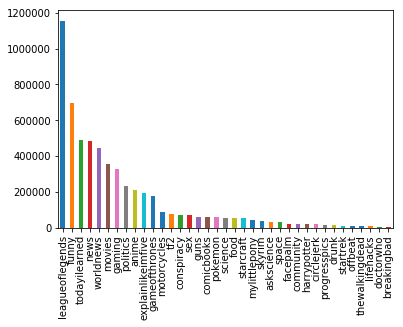

In [6]:
df.subreddit.value_counts().plot(kind='bar')
plt.show()

We'll narrow down our dataset to five popular subreddits on simple topics – [`worldnews`, `movies`, `gaming`, `science`, `food`]

In [7]:
subreddit_list = ['worldnews', 'movies', 'gaming', 'science', 'food']
df = df[df.subreddit.isin(subreddit_list)]

Focusing on specific subreddits has narrowed our number of observations down from 6,195,172 to a much more manageable 1,372,864 comments. Let's explore our the number of observations in our hand-picked subreddits. 

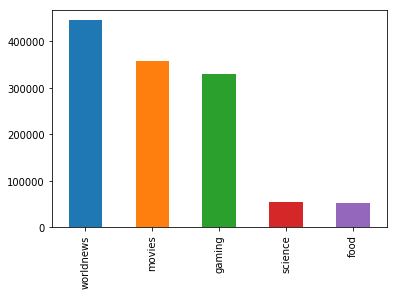

In [8]:
df.subreddit.value_counts().plot(kind='bar')
plt.show()

## Feature Engineering

We are going to do some type conversion of our categorical variables to reduce the memory footprint.

In [9]:
df['subreddit'] = df.subreddit.astype('category')
df['subreddit_id'] = df.subreddit_id.astype('category')
df['distinguished'] = df.distinguished.astype('category')
df['link_id'] = df.link_id.astype('category')

**Deleting Features** In exploring the data, we found that some variables are not helpful for us in our efforts to predict reddit scores. Here are variables that we chose to remove, with a quick reason why we chose to do so – 
- `archived` - There are no archived comments in our reduced dataset. 
- `retrieved_on` - Retrieved at least 104 hours after the comment, far long enough for most threads to die. 
- `id` - The variable `name` also uniquely identifies comments, rendering `id` irrelevant. 
- `removal_reason` - Only 7 comments were deleted (`removal_reason = legal`). We will treat those comments as outliers that would not help in predicting the scores of new comments. 

In [10]:
# The number of hours between when the comment was posted & when it was scraped
t = (df.retrieved_on - df.created_utc) / 60 / 60
t.min()

104.2038888888889

In [11]:
# Remove superfluous explanatory variables
df.drop(['archived', 'retrieved_on', 'id',
         'removal_reason'], axis=1, inplace=True)
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.66802204881596 GB'

Impute missing values of `distinguised`. Missing means the comment was made by a regular user.

In [12]:
# Replace 'NaN' with 'user'
df.distinguished.replace(to_replace=np.NaN, value='user', inplace=True)

Note that we have the original dataset was `5.13GB`. Quite a reduction!

## Recency Based Features

- `time`: timestamp of comment
- `time_lapse`: (in seconds) the amount of time since the first comment in a thread

In [13]:
# Convert created_utc to datetime
df['time'] = pd.to_datetime(df.created_utc, unit='s')

In [14]:
# Find the time of the first comment in a thread
df_first_comment = df[['link_id', 'time']].groupby(by=['link_id']).min()

# Create a dictionary of {link_id -> timestamp} pairs
df_first_comment_dict = df_first_comment.to_dict('index')

# Funct that takes in {link_id, timestamp} pair & returns the time elapsed since the first comment in that link_id.
def time_lapse(x):
    return df_first_comment_dict[x]['time']

# Add a column of the time_elapsed from the first comment in a link_id
df['time_lapse'] = df.time - df.link_id.apply(time_lapse)

# Convert the type of time_lapse back to seconds
df.time_lapse = df.time_lapse.apply(lambda x: x.total_seconds())

An interesting observation is that there are on average `29.3` comments-per-thread.  

In [15]:
# Total comments / unique threads 
len(df.link_id) / len(df.link_id.unique())

29.327461287114648

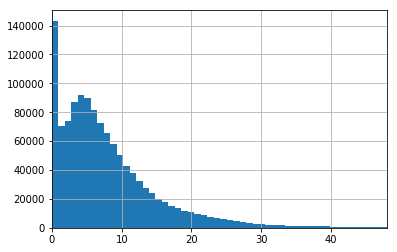

In [16]:
# hours after first comment in thread
(df.time_lapse / (60*60)).hist(bins=800).set_xlim((0, 48));

We see that most comment threads die after 40 hours. Because of this behaviour, we find that the `retrieved_on` feature is rather superfluous, as mentioned above. Thus, we don't worry that the data collection process diminished the score in any particular way. 

## Comment Appearance Based Feautures

- `is_flair`: Whether or not there is flair text for the comment
- `is_flair_css`: Whether or not there is a CSS class for the comment flair

In [17]:
df['is_flair'] = ~df.author_flair_text.apply(lambda x: x is None)
df['is_flair_css'] = ~df.author_flair_css_class.apply(lambda x: x is None)

print(sum(df.is_flair) / len(df.is_flair))
print(sum(df.is_flair_css) / len(df.is_flair_css))

0.007156374534157479
0.003635509310391598


## Parent Based Features

- `depth`: depth of comment in its thread
- `parent_score`: score of parent comment. If no score for a `parent_id` then the value is missing
- `time_since_parent`: time since parent comment in seconds

In [18]:
def pd_to_dict(df, index='', column=''):
    return pd.Series(df[column].values, index=df[index]).to_dict()

comment_to_parent_dict = pd_to_dict(df[['name', 'parent_id']],
                                    index='name', column='parent_id')

def get_depth(x):
    counter = 0
    temp = x
    while True:
        if temp[:3] == 't3_':
            return counter
        try:
            temp = comment_to_parent_dict[temp]
        except KeyError:
            return counter
        counter += 1
        
df['depth'] = df['name'].apply(get_depth)
comment_to_score = pd_to_dict(df[['name', 'score']],
                              index='name', column='score')

def get_parent_score(x):
    try:
        return comment_to_score[x]
    except:
        return np.nan

df['parent_score'] = df.parent_id.apply(lambda x: get_parent_score(x))
# imp_val = df.parent_score.median()
# df.parent_score.fillna(imp_val, inplace=True)

comment_to_time = pd_to_dict(df[['name', 'time']],
                              index='name', column='time')

def get_time_since_parent(pi):
    try:
        return comment_to_time[pi]
    except:
        return np.nan

df['time_since_parent'] = df.parent_id.apply(get_time_since_parent)
df.loc[df.time_since_parent.isna(), 'time_since_parent'] = df.time
df.time_since_parent = df.time - df.time_since_parent
df.time_since_parent = df.time_since_parent.apply(lambda x: x.total_seconds())

In [19]:
sum(df.parent_score != df.parent_score) / len(df.parent_score)

0.31339333578768563

In [20]:
df.head(3).T

,732330,732331,732332
created_utc,1430438556,1430438571,1430438572
ups,4,2,2
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl
score_hidden,0,0,0
author_flair_css_class,None,None,None
author_flair_text,None,None,None
subreddit,food,food,food
gilded,0,0,0


## Comment Tree Based Features

- `comment_tree_root_id`: id of comment tree root.
- `comment_tree_root_score`: score of comment tree root
- `time_since_comment_tree_root`: time since comment tree root in seconds

In [21]:
def get_comment_tree_root(x):
    if comment_to_parent_dict[x][:3] == 't3_':
        return x
    try:
        return get_comment_tree_root(comment_to_parent_dict[x])
    except KeyError:
        return np.nan
    
comment_to_time = pd_to_dict(df[['name', 'time']],
                              index='name', column='time')

def get_time(x):
    try:
        return comment_to_time[x]
    except:
        return np.nan
    
df['comment_tree_root_id'] = df.name.apply(get_comment_tree_root)
df['comment_tree_root_score'] = df.comment_tree_root_id.apply(lambda x: get_parent_score(x))
df['time_since_comment_tree_root'] = df.time - df.comment_tree_root_id.apply(get_time)
df.time_since_comment_tree_root = df.time_since_comment_tree_root.apply(lambda x: x.total_seconds())

In [22]:
print(sum(df.comment_tree_root_id == df.name) / len(df.depth))

0.2836819482390022


## Comment Content Based Features

- `linked_sr` - A list of subreddits mentioned in the comment
- `linked_urls` - A list of urls mentioned in the comment. 
    - We'll limit the amount of URL & subreddit features to the top-15, respectively. We want to use each URL as a binary feature. We don't want the amount of URL features we are going to add to be outrageous.




Perhaps more useful features than respective arrays of subreddits & urls would be a simple count
- `no_of_linked_sr`: count of respective subreddit there were in a given comment
- `no_of_linked_urls`: count of respective urls there were in a given comment 
- `subjectivity` - Count how many times the personal pronoun `I` occurs in a comment. 
- `is_edited`: `edited` is a timestamp that indicates when the comment was last edited. Also useful would be a variable that indicates whether the comment was edited or not.
- `quoted` - Check if the comment quotes another comment. 
- `no_quoted` - Check the number of quotes in a comment

### `linked_sr`

`linked_sr` - A list of subreddits mentioned in the comment.

In [23]:
# Extract an array of subreddit links in a post & use as a feature
df['linked_sr'] = df.body.apply(lambda x: re.findall(r"/r/([^\s/]+)", x))

# Remove the subreddits mentioned from the actual comment
df['body'] = df.body.apply(lambda x: re.sub(r"(/r/[^\s/]+)", '', x))

### `linked_urls`

`linked_urls` - A list of urls mentioned in the comment. 

In [24]:
# Nasty Regular Extraction to extract a link
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def get_domains(x):
    """
    Given a comment (String), extract an array of urls' domain names mentioned in the comment
    """
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    urls = re.findall(url_regex, x)
    try:
        domain_names = [urlparse(url).netloc.split('.')[-2] for url in urls]
    except:
        return []
    return domain_names

# Create the feature for each observation
df['linked_urls'] = df.body.apply(lambda x: get_domains(x))

In [25]:
def remove_urls(x):
    """
    Given a comment, replace the url component with an empty string. 
    """
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    return re.sub(url_regex, '', x)

# Remove the URL from each comment 
df['body'] = df.body.apply(lambda x: remove_urls(x))

### `no_of_linked_sr` & `no_of_linked_urls`

`no_of_linked_sr`, `no_of_linked_urls` - Perhaps more useful features than respective arrays of subreddits & urls would be a simple count of how many respective subreddit & urls there were in a given comment

In [26]:
# Create a how-many-subreddit-links-were-in-this-comment? feature
df['no_of_linked_sr'] = df['linked_sr'].apply(lambda x: len(x))

# Create a how-many-urls-were-in-this-comment? feature
df['no_of_linked_urls'] = df['linked_urls'].apply(lambda x: len(x))

**Notes** - On average there are `0.027` subreddits mentioned per post & `0.077` URLs per post. 

In [27]:
print(f"Subreddit-links-per-post  {sum(df.no_of_linked_sr) / len(df.body)}")
print(f"URL-links-per-post        {sum(df.no_of_linked_urls) / len(df.body)}")

Subreddit-links-per-post  0.028544762864358284
URL-links-per-post        0.08638108986158745


Here is a list of the subreddits most referred to – 

In [28]:
all_linked_sr = []
for l in df.linked_sr.values:
    all_linked_sr += l

top_sr_links = Counter(all_linked_sr)
top_sr_links.most_common(15)

[('worldnews', 4946),
 ('worldnews)', 2796),
 ('worldnews.', 2489),
 ('help', 2387),
 ('worldnews](http:', 2387),
 ('food),', 1594),
 ('gaming', 1435),
 ('food)', 1283),
 ('movies', 1225),
 ('science', 1044),
 ('movies)', 467),
 ('EverythingScience.', 459),
 ('AutoModerator', 452),
 ('conspiracy', 241),
 ('science.', 206)]

Here is a list of the URLs most referred to – 

In [29]:
all_linked_urls = []
for l in df.linked_urls.values:
    all_linked_urls += l

top_url_links = Counter(all_linked_urls)
top_url_links.most_common(15)

[('reddit', 20232),
 ('youtube', 14216),
 ('wikipedia', 11078),
 ('imgur', 8154),
 ('youtu', 3616),
 ('redditblog', 2393),
 ('imdb', 2132),
 ('co', 1811),
 ('theguardian', 823),
 ('google', 733),
 ('github', 606),
 ('wordpress', 556),
 ('nytimes', 508),
 ('twitter', 432),
 ('amazon', 425)]

We'll limit the amount of URL & subreddit features to the top-15, respectively. Why? We want to use each URL as a binary feature. We don't want the amount of URL features we are going to add to be outrageous. 

In [30]:
# Find the most common URLs
allowed_urls = [i[0] for i in top_url_links.most_common(15)]

def remove_urls(x):
    """
    Given a list of URLs, keep only those in the top-15. 
    """
    y = []
    for i in x:
        if i in allowed_urls:
            y += [i]
    return y

# Keep only the popular URLs 
df['linked_urls'] = df['linked_urls'].apply(lambda x: remove_urls(x))

### `subjectivity`

`subjectivity` - Count how many times the personal pronoun `I` occurs in a comment. 

In [31]:
# Implement the above
df['subjectivity'] = df['body'].str.count('I ')

### `is_edited`

`is_edited` – `edited` is a timestamp that indicates when the comment was last edited. Also useful would be a variable that indicates whether the comment was edited or not.

In [32]:
# Create a column indicating if the comment is edited or not
df['is_edited'] = df.edited.apply(lambda x: x > 0)

In [33]:
f"Edited/All = {sum(df.is_edited) / len(df.is_edited)}"

'Edited/All = 0.03151420617850892'

**Notes** - Only 3% of comments were edited.

### `quoted`

`quoted` - Check if the comment quotes another comment. 

In [34]:
# if the comment quotes another comment, indicate that with a boolean
df['is_quoted'] = df.body.str.contains('&gt;')

### `no_quoted`

`no_quoted` - Check the number of quotes in a comment

In [35]:
# Implement the above
df['no_quoted'] = df.body.str.count('&gt;')

In [36]:
df.head(3).T

,732330,732331,732332
created_utc,1430438556,1430438571,1430438572
ups,4,2,2
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl
score_hidden,0,0,0
author_flair_css_class,None,None,None
author_flair_text,None,None,None
subreddit,food,food,food
gilded,0,0,0


**Notes**
- On average there are `0.027` subreddits mentioned per post & `0.077` URLs per post. 
- Only 3% of comments were edited.
- subjectivity is highly skewed, maybe categorical would be better

In [37]:
print(f"Subreddit-links-per-post  {sum(df.no_of_linked_sr) / len(df.body)}")
print(f"URL-links-per-post        {sum(df.no_of_linked_urls) / len(df.body)}")

Subreddit-links-per-post  0.028544762864358284
URL-links-per-post        0.08638108986158745


In [38]:
f"Edited/All = {sum(df.is_edited) / len(df.is_edited)}"

'Edited/All = 0.03151420617850892'

Here is a list of the subreddits most referred to – 

In [39]:
top_sr_links.most_common(15)

[('worldnews', 4946),
 ('worldnews)', 2796),
 ('worldnews.', 2489),
 ('help', 2387),
 ('worldnews](http:', 2387),
 ('food),', 1594),
 ('gaming', 1435),
 ('food)', 1283),
 ('movies', 1225),
 ('science', 1044),
 ('movies)', 467),
 ('EverythingScience.', 459),
 ('AutoModerator', 452),
 ('conspiracy', 241),
 ('science.', 206)]

Here is a list of the URLs most referred to – 

In [40]:
top_url_links.most_common(15)

[('reddit', 20232),
 ('youtube', 14216),
 ('wikipedia', 11078),
 ('imgur', 8154),
 ('youtu', 3616),
 ('redditblog', 2393),
 ('imdb', 2132),
 ('co', 1811),
 ('theguardian', 823),
 ('google', 733),
 ('github', 606),
 ('wordpress', 556),
 ('nytimes', 508),
 ('twitter', 432),
 ('amazon', 425)]

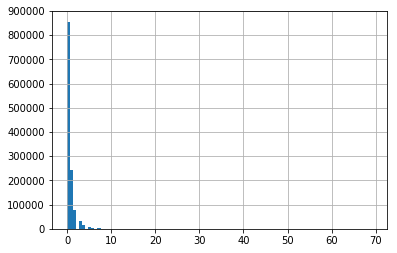

In [41]:
df.subjectivity.hist(bins=100)
plt.show()

In [42]:
df.head(3).T

,732330,732331,732332
created_utc,1430438556,1430438571,1430438572
ups,4,2,2
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl
score_hidden,0,0,0
author_flair_css_class,None,None,None
author_flair_text,None,None,None
subreddit,food,food,food
gilded,0,0,0


## Sentiment Based Features

This cell will take a few minutes to run.
-  `senti_neg`: negative score of comment
- `senti_neu`: neutral score of comment
- `senti_pos`: positive score of comment
- `senti_comp`: compound score of comment

In [43]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# sentiment analyzer
analyser = SentimentIntensityAnalyzer() # http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html

# get sentiment scores 
def get_sentiment(x):
    return analyser.polarity_scores(x)

# get sentiment scores from 'body' column of dataframe
def wrapper_get_sentiment(df):
    df['sentiment'] = df['body'].apply(get_sentiment)
    return df

# to apply operation in parallel
num_partitions = 100
num_cores = 4
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# add a column for each score to our data
sentiment = parallelize_dataframe(df['body'].to_frame(), wrapper_get_sentiment)
sentiment.drop(['body'], axis=1, inplace=True)
df['senti_neg'] = sentiment['sentiment'].apply(lambda x: x['neg'])
df['senti_neu'] = sentiment['sentiment'].apply(lambda x: x['neu'])
df['senti_pos'] = sentiment['sentiment'].apply(lambda x: x['pos'])
df['senti_comp'] = sentiment['sentiment'].apply(lambda x: x['compound'])
del sentiment

/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [44]:
print(df.shape)
df.head(3).T

(1238616, 40)


,732330,732331,732332
created_utc,1430438556,1430438571,1430438572
ups,4,2,2
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl
score_hidden,0,0,0
author_flair_css_class,None,None,None
author_flair_text,None,None,None
subreddit,food,food,food
gilded,0,0,0


In [45]:
# save sentiment data
# df.to_pickle('Data/sentiment.pkl')

## Comment Length Based Features

- `word_count`: number of words in comment

In [46]:
# get number of words in comment
def get_word_count(df):
    df['word_count'] = df['body'].apply(lambda x: len(x.split()))
    return df

word_counts = parallelize_dataframe(df['body'].to_frame(), get_word_count)
df['word_counts'] = word_counts.word_count
del word_counts

In [47]:
print(df.shape)
df.head(3).T

(1238616, 41)


,732330,732331,732332
created_utc,1430438556,1430438571,1430438572
ups,4,2,2
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl
score_hidden,0,0,0
author_flair_css_class,None,None,None
author_flair_text,None,None,None
subreddit,food,food,food
gilded,0,0,0


In [49]:
# save new data
df.to_pickle('../Data/working_dataset_v1.pkl')

In [50]:
print(f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB")

1.1183990562548234 GB


# Add thread level data

After running the code above, the resulting dataset is `Data/working_dataset_v1.pkl`. This data will now be combined with the PRAW data and the rest of the features will be engineered.

### Read in Benchmark Data and Thread Data

In [51]:
processed_data = pd.read_pickle('../Data/working_dataset_v1.pkl')
f"{processed_data.memory_usage(deep=True).sum() / 1023.0**3} GB"

'1.0703962400897329 GB'

In [53]:
scraped_data = pd.read_pickle('../Data/scrape/df_final.pkl')
f"{scraped_data.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.03810666985135063 GB'

### Original Features

In [54]:
# processed_data.head().T

In [55]:
scraped_data.head().T

,0,1,2,3,4
sub_id,t3_34gagr,t3_34gnav,t3_34fsr0,t3_34erib,t3_34gkc7
created_utc,1.43043e+09,1.43044e+09,1.43042e+09,1.43041e+09,1.43044e+09
distinguished,None,None,None,None,None
edited,False,False,False,False,False
locked,False,False,False,False,False
url,http://www.washingtonpost.com/blogs/wonkblog/w...,http://i.imgur.com/iOF4sI6.jpg,http://i.imgur.com/QN6RLSH.jpg,http://i.imgur.com/gODPprxl.jpg,http://i.imgur.com/2iU1r69.jpg
num_comments,23,3,15,26,14
over_18,False,False,False,False,False
score,131,4,98,220,12
selftext,,,,,


In [56]:
scraped_data['url'] = scraped_data.url.astype('category')
scraped_data['selftext'] = scraped_data.selftext.astype('category')
scraped_data['title'] = scraped_data.title.astype('category')

In [57]:
scraped_data['link_created_time'] = pd.to_datetime(scraped_data.created_utc, unit='s')

In [58]:
scraped_data.drop(['locked', 'downs', 'is_original_content',
          'view_count', 'distinguished', 'edited',
          'num_crossposts', 'spoiler', 'created_utc'], axis=1, inplace=True)

In [59]:
scraped_data.rename(columns={'sub_id':'link_id', 
                    'ups': 'link_ups',
                    'score': 'link_score'}, inplace=True)

In [60]:
scraped_data.tail().T

,45395,45396,45397,45398,45399
link_id,t3_380j06,t3_380k50,t3_380ld3,t3_380lty,t3_380msc
url,https://www.yahoo.com/news/us-demands-immediat...,http://www.irishtimes.com/news/world/middle-ea...,http://www.timesofisrael.com/israels-army-skir...,http://time.com/3902702/us-college-student-isi...,http://www.healthy4u.net/2015/05/30/easy-diet-...
num_comments,10,1,6,5,1
over_18,False,False,False,False,False
link_score,9,9,0,8,1
selftext,,,,,
title,"US hits out at China over sea reclamation, vow...",Israel moves to toughen sentences for stone-th...,Israel's Army operating program to convert Jew...,Hero Student Tries to Stop ISIS Attack in Saud...,easy diet
upvote_ratio,0.62,0.84,0.38,0.68,1
link_ups,9,9,0,8,1
link_created_time,2015-05-31 23:19:50,2015-05-31 23:29:11,2015-05-31 23:38:41,2015-05-31 23:42:18,2015-05-31 23:50:20


In [61]:
f"{scraped_data.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.028195456273879205 GB'

In [81]:
df = processed_data.merge(scraped_data, on='link_id', how='left')

In [82]:
df['time_since_link'] = (df.time - df.link_created_time)
df.time_since_link = [x.total_seconds() for x in df.time_since_link]

In [83]:
df.shape

(1238616, 51)

In [84]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'1.38562313303201 GB'

In [85]:
df.head().T

,0,1,2,3,4
created_utc,1430438556,1430438571,1430438572,1430438641,1430438722
ups,4,2,2,1,1
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4,t3_34drd4,t3_34c9s7
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl,t1_cqugdz8,t1_cqugfp1
score_hidden,0,0,0,0,0
author_flair_css_class,None,None,None,None,None
author_flair_text,None,None,None,None,None
subreddit,food,food,food,food,food
gilded,0,0,0,0,0


In [86]:
# drops about 2000 rows due to link_id not in scraped_data
df = df.iloc[np.where(df.title == df.title)]
print(df.shape)
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

(1236322, 51)


'1.383016837337031 GB'

## Engineer new features

- `is_root`: whether or not the parent comment is a thread
- `is_selftext`: whether or not the parent thread contains selftext

some changes to storage type of `url` are also made

In [87]:
df['url'] = df.url.astype('str').apply(lambda x: urlparse(x)[1])
df['url'] = df.url.astype('category')
df['is_root'] = df.parent_id.str.startswith('t3_')
df['is_selftext'] = df.selftext.str.len() > 1

## Comment2Vec Based Features

- `parent_cos_angle`: consine similarity between comment and its parent comment's embeddings
- `title_cos_angle`: consine similarity between comment and its thread's title's embeddings

In [88]:
table = str.maketrans({key: ' ' for key in string.digits + string.punctuation + '\t\n\r'})

num_partitions = 100
num_cores = 6
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def pd_to_dict(df, index='', column=''):
    return pd.Series(df[column].values, index=df[index]).to_dict()

def load_glove(filename):
    glove = {}
    with open(filename, 'r') as read_file:
        for line in read_file:
            key = line.split(' ')[0]
            vector = np.array(line.split(' ')[1:], dtype=np.float)
            glove[key] = vector

    return glove

def words(text):
    text = text.lower()
    text = text.translate(table).strip()
    terms = text.split(' ')
    terms = [t for t in terms if len(t) > 2]
    terms = [t for t in terms if t not in ENGLISH_STOP_WORDS]

    return terms

def get_doc2vec(text, gloves):
    count_words = 0
    final_vector = 0
    terms = words(text)
    for t in terms:
        if t in gloves.keys():
            count_words += 1
            final_vector += gloves[t]
    if count_words != 0:
        return final_vector / count_words
    else:
        return None

gloves = load_glove('../Data/glove.twitter.27B.200d.txt')

comment_to_body = pd_to_dict(df[['name', 'body']],
                                index='name', column='body')
comment_to_parent = pd_to_dict(df[['name', 'parent_id']],
                                index='name', column='parent_id')

def get_cosine_angle(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_body[comment_to_parent[cmnt_id]]
    except KeyError:
        return None
    child = get_doc2vec(child, gloves)
    parent = get_doc2vec(parent, gloves)
    if child is None:
        return None
    if parent is None:
        return None
    return cosine(child, parent), euclidean(child, parent)

def wrapper_get_cosine(df):
    df['cosine_euc'] = df['name'].apply(get_cosine_angle)
    return df

cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine)

df['cosine_euc'] = cosine_angle.cosine_euc

del cosine_angle

df['parent_cosine'] = df.cosine_euc.apply(lambda x: x[0] if x is not None else None)
df['parent_euc'] = df.cosine_euc.apply(lambda x: x[1] if x is not None else None)

df.drop(['cosine_euc'], inplace=True, axis=1)

comment_to_body = pd_to_dict(df[['name', 'body']],
                                index='name', column='body')
comment_to_title = pd_to_dict(df[['name', 'title']],
                                index='name', column='title')

def get_cosine_angle(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_title[cmnt_id]
        child = get_doc2vec(child, gloves)
        parent = get_doc2vec(parent, gloves)
    except:
        return None
    if child is None:
        return None
    if parent is None:
        return None
    return cosine(child, parent), euclidean(child, parent)

def wrapper_get_cosine(df):
    df['cosine_euc'] = df['name'].apply(get_cosine_angle)
    return df

cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine)
df['cosine_euc'] = cosine_angle.cosine_euc
del cosine_angle

df['title_cosine'] = df.cosine_euc.apply(lambda x: x[0] if x is not None else None)
df['title_euc'] = df.cosine_euc.apply(lambda x: x[1] if x is not None else None)

In [89]:
df.head().T

,0,2,3,5,6
created_utc,1430438556,1430438572,1430438641,1430438762,1430438833
ups,4,2,1,2,0
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34drd4,t3_34drd4,t3_34gkc7,t3_34fsr0
name,t1_cqugc7x,t1_cqugcjl,t1_cqugdz8,t1_cquggkz,t1_cqugi3n
score_hidden,0,0,0,0,0
author_flair_css_class,None,None,None,None,None
author_flair_text,None,None,None,None,None
subreddit,food,food,food,food,food
gilded,0,0,0,0,0


In [90]:
print(df.shape)
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

(1236322, 58)


'1.468654295151343 GB'

In [91]:
sum(df.parent_euc != df.parent_euc) / df.shape[0]

0.33786343687162407

In [93]:
print(sum(df.parent_cosine != df.parent_cosine) / df.shape[0])
print(sum(df.parent_euc != df.parent_euc) / df.shape[0])
print(sum(df.title_cosine != df.title_cosine) / df.shape[0])
print(sum(df.title_euc != df.title_euc) / df.shape[0])

0.33786343687162407
0.33786343687162407
0.02530327859570565
0.02530327859570565


Some histograms are plotted below to get an idea of the distrubution of columns with missing values

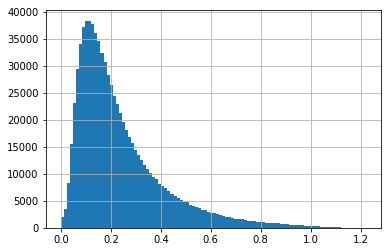

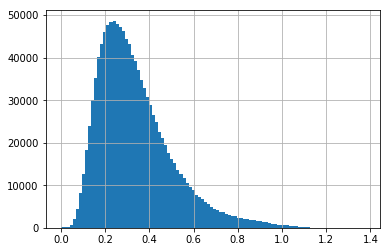

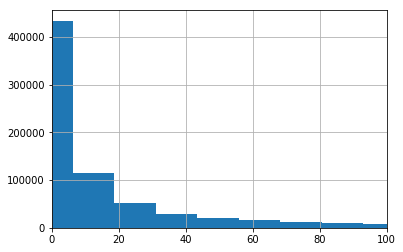

In [96]:
df.parent_cosine.hist(bins=100)
plt.show()
df.title_cosine.hist(bins=100)
plt.show()
df.parent_score.hist(bins=500)
plt.xlim([0,100])
plt.show()

In [98]:
print(df.shape)
df.to_pickle('../Data/working_dataset_v2.pkl')

(1236322, 58)


In [100]:
print(f"{processed_data.memory_usage(deep=True).sum() / 1023.0**3} GB")
df.head().T

1.079374396711071 GB


,0,2,3,5,6
created_utc,1430438556,1430438572,1430438641,1430438762,1430438833
ups,4,2,1,2,0
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34drd4,t3_34drd4,t3_34gkc7,t3_34fsr0
name,t1_cqugc7x,t1_cqugcjl,t1_cqugdz8,t1_cquggkz,t1_cqugi3n
score_hidden,0,0,0,0,0
author_flair_css_class,None,None,None,None,None
author_flair_text,None,None,None,None,None
subreddit,food,food,food,food,food
gilded,0,0,0,0,0


## Thread Activity Based Features

- `epoch_time`: time in secondes since an origin
- `no_past_comments`: number of comments on thread before this comment was posted
- `score_till_now`: score of thread at the time this comment was posted

In [ ]:
df = pd.read_pickle('../Data/working_dataset_v2.pkl')

In [14]:
df['epoch_time'] = df.time.astype(np.int64) // 10**9

In [7]:
def get_past_stats_dict(lid):
    dfs = df[df.link_id == lid][['time', 'score', 'name']]
    dfs = dfs.sort_values(by='time', ascending=True).reset_index(drop=True)
    dfs.reset_index(inplace=True)
    t_dict = pd.DataFrame(data=dfs[['index', 'score']].values,
                        index=dfs['name'].values,
                        columns=['no_of_comments', 'score']).to_dict('index')
    return t_dict

num_cores = 6
pool = Pool(num_cores)
list_dicts = pool.map(get_past_stats_dict, df.link_id.unique())

y = pd.concat([pd.DataFrame.from_dict(d, orient='index') for d in list_dicts])
y = y.to_dict('index')

df['no_of_past_comments'] = df.name.apply(lambda x: y[x]['no_of_comments'])
df['score_till_now'] = df.name.apply(lambda x: y[x]['score'])

In [15]:
print(df.shape)
print(f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB")
df.head().T

(1236322, 61)
1.504122933807588 GB


,0,2,3,5,6
created_utc,1430438556,1430438572,1430438641,1430438762,1430438833
ups,4,2,1,2,0
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34drd4,t3_34drd4,t3_34gkc7,t3_34fsr0
name,t1_cqugc7x,t1_cqugcjl,t1_cqugdz8,t1_cquggkz,t1_cqugi3n
score_hidden,0,0,0,0,0
author_flair_css_class,None,None,None,None,None
author_flair_text,None,None,None,None,None
subreddit,food,food,food,food,food
gilded,0,0,0,0,0


In [12]:
# df = pd.to_pickle('../Data/Data_Finale.pkl')
df.to_pickle('../Data/Data_Finale1.pkl')